### 01 Data Generation for ML training

Here, I perform the [Monte-Carlo simulations](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) of a [2D Ising spin model](https://en.wikipedia.org/wiki/Ising_model), and generate the datasets for training, validation, and testing.

In [1]:
from init import *

2023-07-18 01:26:40.001610: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-18 01:26:40.005487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ss/gsl/gsl-2.7.1/.libs
2023-07-18 01:26:40.005500: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Save the generated data into these folders:

In [2]:
train_path = "data/train"
valid_path = "data/valid"
os.makedirs(train_path, exist_ok=True)
os.makedirs(valid_path, exist_ok=True)

### Create the lattice

First, we start with a square lattice of size $L\times L$, where spins (either $\uparrow$ or $\downarrow$) are randomly arranged, representing a paramagnetic state. Numerically, spins can be representated as $+1$ or $-1$.  

In [3]:
@njit
def MakeLattice(L):
    """
    Parameters:
        L: size of the lattice
    """
    mat = np.ones(shape=(L,L), dtype=np.int64)
    return mat

### [Wolff algorithm](https://en.wikipedia.org/wiki/Wolff_algorithm) for spin-flip
* The spin clusters are randomly picked and flipped.
* If flipping lowers the energy, the move is accepted. Otherwise, the move is accepted with the Boltzmann probability $\propto e^{-E/k_B T}$.
* Here, the energy is: $E = -\sum_{\langle ij \rangle} s_i \, s_j$, where $s_{i(j)}$ refers to spin at site $i(j)$, and $\langle ij \rangle$ denotes sum over nearest-neighbour only.

In [4]:
@njit #njit is used for speedup
def flipCluster(mat,cluster):
    """
    Flip all spins in a cluster. Used for the Wolff algorithm.

    Parameters:
        mat: numpy array containing the current spin configuration
        cluster: List of spins to be flipped 
    """
    for pair in cluster:
        i,j=pair
        mat[i,j]*=-1

@njit
def iterateWolff(mat,T,calcE=False):
    """
    Wolff algorithm for a square lattice
     
    Parameters:
        mat: numpy array containing the current spin configuration
        T: Temperature for the simulation
        calcE: Flag to calculate and return the average spin energy for the final configuration.
    """
    L,_ = mat.shape
    tracker = np.zeros((L,L), dtype=np.int64) # Keep track of which spins have already be added to the cluster.
    
    i,j = np.random.randint(0,L,size=2)
    spin = mat[i,j]
    stack = [(i,j)]
    tracker[i,j]=1
    
    cluster = [(i,j)]
    while len(stack)>0:
        i,j = stack.pop()
        neighbors = [(i,(j+1)%L),(i,(j-1)%L),((i+1)%L,j),((i-1)%L,j)]
        for pair in neighbors:
            l,m = pair
            if (mat[l,m]==spin and tracker[l,m]==0 and np.random.random()< (1.0-np.exp(-2.0/T))):
                cluster.append((l,m))
                stack.append((l,m))
                tracker[l,m]=1
            
    flipCluster(mat,cluster)
            
    if calcE:
        avgE=0.0
        for i in range(L):
            for j in range(L):
                spin_final = mat[i,j]
                neighbor_sum = mat[(i+1)%L,j]+mat[(i-1)%L,j]+mat[i,(j+1)%L]+mat[i,(j-1)%L]
                E_final = -spin_final*neighbor_sum
                avgE+=float(E_final)
    
        avgE/=float(L**2)                   
        return avgE

### Data generation

In [5]:
@njit
def simulate(mat,T,Nstep):
    #MC simulation for a square lattice, using the Wolff algorithm
    for step in range(Nstep):
        iterateWolff(mat,T)

def GenerateSamples(T, L, Nstep, Nsample, path, Tc=2.27):
    """
    Creates "Nsample" no. of copies of a spin system of size LxL at temp. T,
    after it has been thermalized with "Nsteps" no. of Monte-Carlo steps
    """
    for sample in range(1, Nsample+1):
        mat = MakeLattice(L)
        simulate(mat,T,Nstep)
        if T<Tc: #Tc~2.27 for square lattice
            category='low'
        else:
            category='high'
        np.save(os.path.join(path, f"{category}_{T:.2f}_{sample}"), mat) #saves the spin config. with category, temp., and label

### Thermalization: When to save the data
In the simulation, spins are flipped `Nstep` no. of times to reach the desired spin configuration at temperature $T$. Here, an important question is how large `Nstep` should be. We can plot the average energy in each step to get an estimate. 

In [6]:
def AverageEnergy(T, Nstep, L=20):
    avgE = np.zeros(Nstep, dtype=float)
    mat = MakeLattice(L)
    for step in range(Nstep):
        avgE[step] = iterateWolff(mat,T,True)
    return avgE

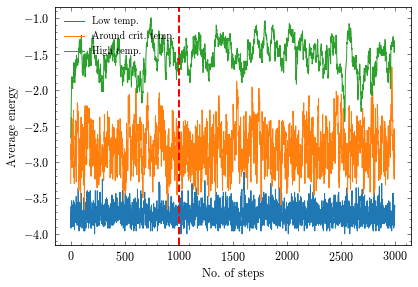

In [7]:
Nstep=3000
steps = np.arange(1, Nstep+1)
avgE1 = AverageEnergy(1.8, Nstep)
avgE2 = AverageEnergy(2.3, Nstep)
avgE3 = AverageEnergy(3.1, Nstep)
plt.ylabel('Average energy')
plt.xlabel('No. of steps')
plt.plot(steps, avgE1, label='Low temp.')
plt.plot(steps, avgE2, label='Around crit. temp.')
plt.plot(steps, avgE3, label='High temp.')
plt.axvline(x=1000, ls='--', c='r', lw=2) #Thermalization cutoff
plt.legend()


For `Nstep=3000`, average energy for all three temperature points becomes stable after 1000 steps (red dashed line). Equlibrium is reached at this point, and therefore, we set `Nstep=1000` when generating datasets.

In [8]:
Tc = 2.27 #critical temp. for square lattice
T_list = np.concatenate((np.arange(1.5,3.5,0.1),np.arange(Tc-0.3,Tc+0.3,0.05))) #takes denser points around Tc
np.sort(T_list)

array([1.5 , 1.6 , 1.7 , 1.8 , 1.9 , 1.97, 2.  , 2.02, 2.07, 2.1 , 2.12,
       2.17, 2.2 , 2.22, 2.27, 2.3 , 2.32, 2.37, 2.4 , 2.42, 2.47, 2.5 ,
       2.52, 2.6 , 2.7 , 2.8 , 2.9 , 3.  , 3.1 , 3.2 , 3.3 , 3.4 ])

Now we generate $20\times 20$ spin configuration for tempratures in `T_list`. Since spin configurations are stochastic, we generate `Nsample=500` no. of samples for each temperature. This process is parallelized with `multiprocessing` to save time. Particularly, `starmap` generates spin configs. with `args` parameters, and saves them into desired folders.

### Warning!!! Takes long time to generate (reduce Nsample to speedup)
Training data

In [12]:
%%time
Nsample=500; L=20; Nstep=1000
args=zip(T_list, repeat(L), repeat(Nstep), repeat(Nsample), repeat(train_path))
Ncores=mp.cpu_count()
p = mp.Pool(Ncores)
p.starmap(GenerateSamples, args)
p.close()
p.join()

CPU times: user 104 ms, sys: 67.5 ms, total: 172 ms
Wall time: 1min 17s


Validation data

In [13]:
%%time
Nsample=200; L=20; Nstep=1000
args=zip(T_list, repeat(L), repeat(Nstep), repeat(Nsample), repeat(valid_path))
Ncores=mp.cpu_count()
p = mp.Pool(Ncores)
p.starmap(GenerateSamples, args)
p.close()
p.join()

CPU times: user 132 ms, sys: 100 ms, total: 233 ms
Wall time: 30 s


---
### Some examples

* Low temperature, ferromagnetic state ($T<< T_c$): spins either point up or downwards, i.e., uniform colors dots everywhere

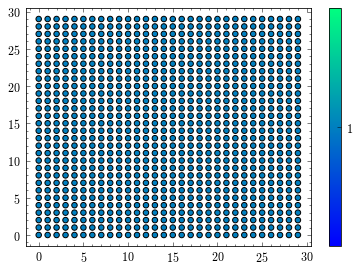

In [9]:
L=30
mat = MakeLattice(L) #create initial spin configuration
simulate(mat, T=0.5, Nstep=3000) #simulate low temp.
Rlist = np.array([m*np.array([1, 0]) + n*np.array([0, 1]) for m in range(L) for n in range(L)]) #create lattice
plt.scatter(Rlist[:,0], Rlist[:,1], s=30, ec='k', c=mat, cmap='winter') #plot lattice and spins
plt.colorbar(ticks=[-1,1])

* Close to Curie temperature $T\rightarrow T_c (\approx2.27)$, spin clusters start to form that indicates transition

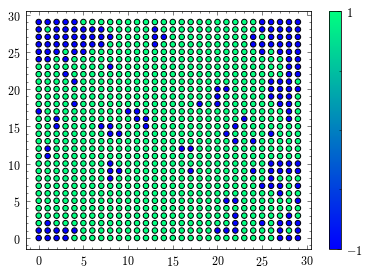

In [10]:
L=30
mat = MakeLattice(L) #create initial spin configuration
simulate(mat, T=2.3, Nstep=3000) #simulate Curie temp.
Rlist = np.array([m*np.array([1, 0]) + n*np.array([0, 1]) for m in range(L) for n in range(L)]) #create lattice
plt.scatter(Rlist[:,0], Rlist[:,1], s=30, ec='k', c=mat, cmap='winter') #plot lattice and spins
plt.colorbar(ticks=[-1,1])

* At high temperatures ($T>>T_C$), the magnetization is lost. Thus, the system becomes paramagnetic with almost equal number of up and down spins.

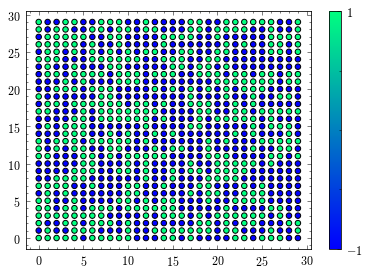

In [11]:
L=30
mat = MakeLattice(L) #create initial spin configuration
simulate(mat, T=10, Nstep=3000) #simulate high temp.
Rlist = np.array([m*np.array([1, 0]) + n*np.array([0, 1]) for m in range(L) for n in range(L)]) #create lattice
plt.scatter(Rlist[:,0], Rlist[:,1], s=30, ec='k', c=mat, cmap='winter') #plot lattice and spins
plt.colorbar(ticks=[-1,1])